In [130]:
#Import all the necessary packages

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("train.csv", index_col=0)
df.shape


(891, 11)

In [3]:
#We split the dataframe into training and testing data, looking to predict whether or not a given passenger survived.

X_train, X_test, y_train, y_test = train_test_split(df.drop(['Survived'], axis=1), df['Survived'])


In [4]:
# Creates copies of the features dataframe to add engineered data
X_train_engineered = X_train
X_test_engineered = X_test

<AxesSubplot:ylabel='PassengerId'>

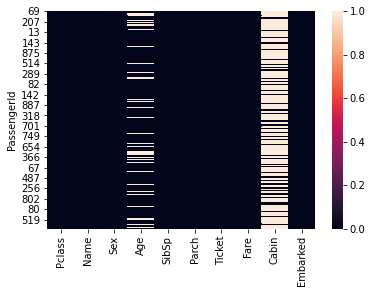

In [5]:
# Display the locations of the NaN values in the features
sns.heatmap(X_train.isna())

In [6]:
# We calculate the median age of passengers in the training data
med_age_train = X_train["Age"].median()
med_age_train

29.0

In [7]:
X_train_engineered["Age"].fillna(med_age_train, inplace=True)

<AxesSubplot:ylabel='PassengerId'>

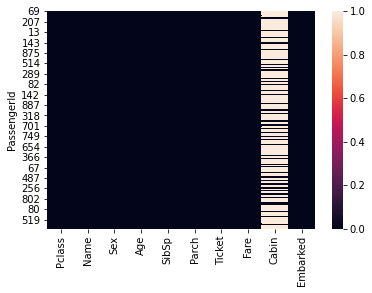

In [8]:
sns.heatmap(X_train_engineered.isna())

In [9]:
X_train_engineered.isna().sum()

# The only remaining columns with NaN values remaining are "Cabin" and "Embarked". 

Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       505
Embarked      1
dtype: int64

In [10]:
# We check whether there is a strong correlation between "Cabin" and "Pclass" in the training set.
X_train_engineered["Cabin"].value_counts()
X_train_engineered["Cabin"].str[0].unique() #returns initial of the cabin number



array([nan, 'B', 'C', 'E', 'A', 'D', 'F', 'G', 'T'], dtype=object)

In [11]:
cabin_ini = X_train_engineered["Cabin"].str[0]

X_train_engineered["Pclass"].size

668

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

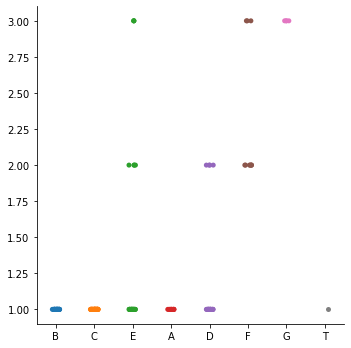

In [12]:
sns.catplot(x=cabin_ini, y= X_train_engineered["Pclass"], data = X_train_engineered)

In the limited data that is available, there appears to be a link between Deck (first letter of cabin nr) and class, but there is not enough data to impute Deck from class info

We can now check if there is a link between ticket price and Deck/Cabin nr:

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

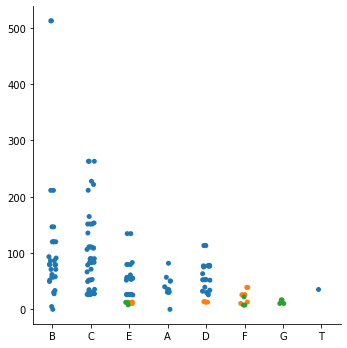

In [13]:
sns.catplot(x=cabin_ini, y= X_train_engineered["Fare"], data= X_train_engineered, hue="Pclass", legend= True)

This also seems inconclusive, so I will drop the "Cabin" column rather than using it in the model

In [14]:
#sns.heatmap(X_train_engineered.corr(), annot=True)

In [15]:
X_train_engineered.drop(columns=["Cabin", 'Embarked', "Ticket", "Name" ], inplace=True)


<AxesSubplot:ylabel='PassengerId'>

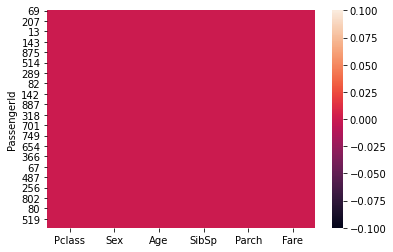

In [16]:
sns.heatmap(X_train_engineered.isna())

In [17]:
X_train_engineered.isna().sum()

Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64

Next we split the Age category into bins for each "stage of life" and one-hot encode:

In [18]:
q = pd.cut(X_train_engineered['Age'], bins=[0,1,13,20,30, 60, 100], labels = ["age_baby", "age_child", "age_teen", "age_young_adult", "age_adult", "age_senior"])
q.value_counts()

age_young_adult    301
age_adult          213
age_teen            84
age_child           42
age_senior          19
age_baby             9
Name: Age, dtype: int64

In [19]:
X_train_engineered.shape

(668, 6)

In [20]:
onehot_age = pd.get_dummies(q)
onehot_age.head()

X_train_engineered = pd.concat([X_train_engineered, onehot_age], axis = 1)
X_train_engineered.shape


(668, 12)

In [21]:
X_train_engineered.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,age_baby,age_child,age_teen,age_young_adult,age_adult,age_senior
PassengerId,,,,,,,,,,,,
69,3,female,17.0,4,2,7.925,0,0,1,0,0,0
261,3,male,29.0,0,0,7.750,0,0,0,1,0,0
415,3,male,44.0,0,0,7.925,0,0,0,0,1,0
736,3,male,28.5,0,0,16.100,0,0,0,1,0,0
140,1,male,24.0,0,0,79.200,0,0,0,1,0,0


Similarly, we one-hot encode sex and passenger class

In [22]:
onehot_sex = pd.get_dummies(X_train_engineered['Sex'], prefix="sex_")
onehot_sex.shape

(668, 2)

In [23]:
X_train_engineered = pd.concat([X_train_engineered, onehot_sex], axis = 1)
X_train_engineered.shape

(668, 14)

In [24]:
onehot_class = pd.get_dummies(X_train_engineered['Pclass'], prefix="pclass")
onehot_class.head()

,pclass_1,pclass_2,pclass_3
PassengerId,,,
69,0,0,1
261,0,0,1
415,0,0,1
736,0,0,1
140,1,0,0


In [25]:
X_train_engineered = pd.concat([X_train_engineered, onehot_class], axis = 1)
X_train_engineered.shape

(668, 17)

In [26]:
X_train_engineered.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,age_baby,age_child,age_teen,age_young_adult,age_adult,age_senior,sex__female,sex__male,pclass_1,pclass_2,pclass_3
PassengerId,,,,,,,,,,,,,,,,,
69,3,female,17.0,4,2,7.925,0,0,1,0,0,0,1,0,0,0,1
261,3,male,29.0,0,0,7.750,0,0,0,1,0,0,0,1,0,0,1
415,3,male,44.0,0,0,7.925,0,0,0,0,1,0,0,1,0,0,1
736,3,male,28.5,0,0,16.100,0,0,0,1,0,0,0,1,0,0,1
140,1,male,24.0,0,0,79.200,0,0,0,1,0,0,0,1,1,0,0


In [27]:
X_train_engineered["Parch"].value_counts()

0    509
1     88
2     61
5      4
3      3
4      2
6      1
Name: Parch, dtype: int64

In [28]:
qparch = pd.cut(X_train_engineered['Parch'], bins=[-1,0,1,2,100], labels = ["0 parch", "1 parch", "2 parch", ">2 parch"])
qparch.value_counts()

0 parch     509
1 parch      88
2 parch      61
>2 parch     10
Name: Parch, dtype: int64

In [29]:
onehot_parch = pd.get_dummies(qparch)
onehot_parch.head()

X_train_engineered = pd.concat([X_train_engineered, onehot_parch], axis = 1)
X_train_engineered.shape

(668, 21)

In [30]:
X_train_engineered["SibSp"].value_counts()

0    461
1    159
2     17
4     12
3     12
5      4
8      3
Name: SibSp, dtype: int64

In [31]:
qsib = pd.cut(X_train_engineered['SibSp'], bins=[-1,0,1,100], labels = ["0 sibsp", "1 sibsp", ">=2 sibsp"])
qsib.value_counts()


0 sibsp      461
1 sibsp      159
>=2 sibsp     48
Name: SibSp, dtype: int64

In [32]:
onehot_sibsp = pd.get_dummies(qsib)
onehot_sibsp.head()

,0 sibsp,1 sibsp,>=2 sibsp
PassengerId,,,
69,0,0,1
261,1,0,0
415,1,0,0
736,1,0,0
140,1,0,0


In [33]:

X_train_engineered = pd.concat([X_train_engineered, onehot_sibsp], axis = 1)
X_train_engineered.shape

(668, 24)

In [34]:
X_train_engineered.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,age_baby,age_child,age_teen,age_young_adult,...,pclass_1,pclass_2,pclass_3,0 parch,1 parch,2 parch,>2 parch,0 sibsp,1 sibsp,>=2 sibsp
PassengerId,,,,,,,,,,,,,,,,,,,,,
69,3,female,17.0,4,2,7.925,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
261,3,male,29.0,0,0,7.750,0,0,0,1,...,0,0,1,1,0,0,0,1,0,0
415,3,male,44.0,0,0,7.925,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
736,3,male,28.5,0,0,16.100,0,0,0,1,...,0,0,1,1,0,0,0,1,0,0
140,1,male,24.0,0,0,79.200,0,0,0,1,...,1,0,0,1,0,0,0,1,0,0


Now we make models for the data:

In [93]:
#m_dummy=DummyClassifier(strategy='uniform')
# Assigns Survival status 0 or 1 with equal probability

m_dummy=DummyClassifier(strategy='most_frequent')
# Assigns Survival status 0 to all


In [94]:
m_dummy.fit(X_train_engineered, y_train)

DummyClassifier(constant=None, random_state=None, strategy='most_frequent')

In [95]:
ypred_dummy = m_dummy.predict(X_train_engineered)
#ypred_dummy


In [96]:
accuracy_score(ypred_dummy, y_train)

0.6227544910179641

In [43]:
m_logistic = LogisticRegression()

In [44]:
X_train_engineered.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'age_baby',
       'age_child', 'age_teen', 'age_young_adult', 'age_adult', 'age_senior',
       'sex__female', 'sex__male', 'pclass_1', 'pclass_2', 'pclass_3',
       '0 parch', '1 parch', '2 parch', '>2 parch', '0 sibsp', '1 sibsp',
       '>=2 sibsp'],
      dtype='object')

In [84]:
#columns = [c for c in X_train_engineered.columns if "age" in c or 'parch' in c]

columns = [c for c in X_train_engineered.columns if "pclass" in c or "sex" in c or "age" in c]
X_input = X_train_engineered[columns]
columns 

['age_baby',
 'age_child',
 'age_teen',
 'age_young_adult',
 'age_adult',
 'age_senior',
 'sex__female',
 'sex__male',
 'pclass_1',
 'pclass_2',
 'pclass_3']

In [85]:
m_logistic.fit(X_input, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
ypred_logi = m_logistic.predict(X_input)

In [87]:
accuracy_score(ypred_logi, y_train)

0.7874251497005988

In [88]:
# What are the parameter coefficients?
w = m_logistic.coef_[0] 


b= m_logistic.intercept_
w, b

(array([ 1.6597768 ,  0.38683142, -0.15952029, -0.34282241, -0.4577805 ,
        -1.08614897,  1.21675196, -1.21641591,  0.96439655,  0.03628888,
        -1.00034938]),
 array([0.35069402]))

In [146]:
X_train_engineered.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'age_baby',
       'age_child', 'age_teen', 'age_young_adult', 'age_adult', 'age_senior',
       'sex__female', 'sex__male', 'pclass_1', 'pclass_2', 'pclass_3',
       '0 parch', '1 parch', '2 parch', '>2 parch', '0 sibsp', '1 sibsp',
       '>=2 sibsp'],
      dtype='object')

In [179]:
#columns = [c for c in X_train_engineered.columns if "age" in c or 'parch' in c]

columns = [c for c in X_train_engineered.columns if "sex" in c or "age" in c]
X_input = X_train_engineered[columns]
columns 

['age_baby',
 'age_child',
 'age_teen',
 'age_young_adult',
 'age_adult',
 'age_senior',
 'sex__female',
 'sex__male']

In [180]:
m_logistic.fit(X_input, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [181]:
ypred_logi = m_logistic.predict(X_input)

In [182]:
accuracy_score(ypred_logi, y_train)

0.7859281437125748

# Random Forest


In [222]:
columns = [c for c in X_train_engineered.columns if "sex" in c or "age" in c]
X_input = X_train_engineered[columns]
columns 

['age_baby',
 'age_child',
 'age_teen',
 'age_young_adult',
 'age_adult',
 'age_senior',
 'sex__female',
 'sex__male']

In [231]:
m_forest = RandomForestClassifier(n_estimators=10, max_depth=2)

In [232]:
m_forest.fit(X_input,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [233]:
ypred_forest = m_forest.predict(X_input)

In [234]:
accuracy_score(ypred_forest, y_train)

0.7859281437125748